In [1]:
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from ipywidgets import interact

In [2]:
# Setup
import locale
locale.setlocale(locale.LC_ALL, "pt-BR.utf8")

sns.set(
    style="ticks",
    context="notebook",
    palette="colorblind"
)
%matplotlib inline

# Desafio: Prepare seu dataset para modelagem de dados

## Contexto

Uma empresa do ramo de e-commerce contratou você para levantar os indicadores de
recência, frequência e ticket médio (RFM) dos seus clientes.<br>
A saber RFM:
- R (Recency): Tempo que o cliente realizou a última compra (em dias)
- F (Frequency): Quantidade de compras realizadas pelo cliente
- M (Monetary): Valor do ticket médio gasto pelo cliente
<br>
onde ticket médio = média do total gasto por pedido para cada cliente.<br><br>
Para isso, vocês receberam uma base de dados (arquivo csv) e devem construir um
código em Python que gera um output também csv, porém contendo apenas a
identificação do cliente e métricas RFM.

## Sobre os dados
A tabela contém informações de compras de um e-commerce em 37 países. Contém a
identificação do cliente e os dados da compra.

|Coluna|Descrição|
|:-----|:--------|
|**CustomerId**|Código de identificação do cliente|
|**Description**|Descrição do produto|
|**InvoiceNo**|Código da fatura|
|**StockCode**|Código de estoque do produto|
|**Quantity**|Quantidade do produto|
|**InvoiceData**|Data do faturamento (compra)|
|**UnitPrice**|Preço unitário do produto|

# Etapa 01 - Leitura e inspeção dos dados

In [3]:
# Carregando o dataset
df_raw = pd.read_csv("data.csv", encoding="unicode_escape")

# Visualizando as primeiras linhas
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# Visualizando informações do dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# Visualizandoa algumas estatísticas
df_raw.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Etapa 02 - Verificação de dados faltantes

In [6]:
# Verificando se há dados faltantes
df_raw.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

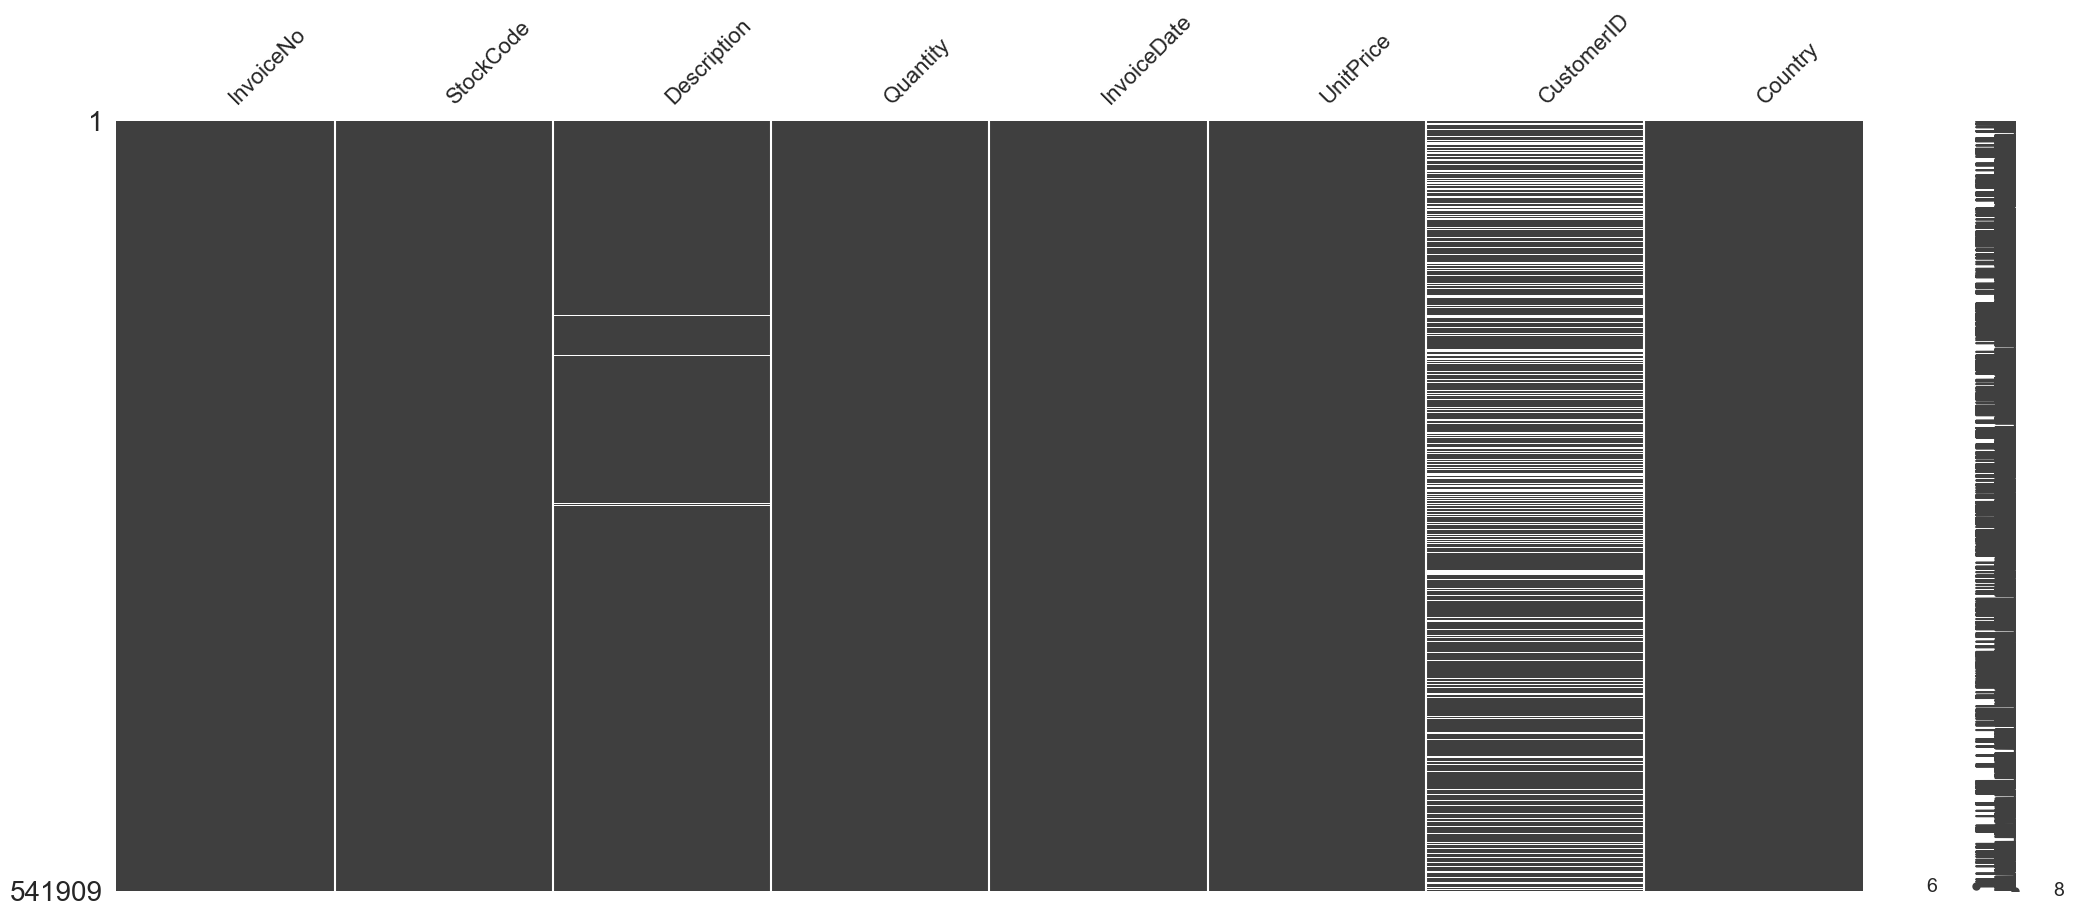

In [7]:
# Visualizando os dados faltantes
missingno.matrix(df_raw);

In [8]:
# Removendo as linhas com dados faltantes em CustomerID
df = df_raw.copy()
df = df.dropna(subset="CustomerID")
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
# Porcentagem de dados faltante em CustomerID
print(f"{1 - len(df) / len(df_raw):.2%}")

24.93%


## Etapa 03 - Verificação de preços unitários e quantidade de produtos

In [10]:
# Verificando dados nulos ou menores que zero na coluna de preços
len(df[(df["UnitPrice"].isna() ) | (df["UnitPrice"] <= 0)])

40

In [11]:
# Filtrando o dataset para conter somente preços acima de zero
df = df[df["UnitPrice"] > 0]

# Verificando dados nulos ou menores que zero na coluna de quantidade
len(df[(df["Quantity"].isna()) | (df["Quantity"] <= 0)])

8905

In [12]:
# Filtrando o dataset para conter somente quantidade acima de zero
df = df[df["Quantity"] > 0]

## Etapa 04 - Verificação de linhas duplicadas

In [13]:
# Verificando linhas duplicadas
df.duplicated().sum()

5192

In [14]:
# Dropando linhas duplicadas
df = df.drop_duplicates(keep="first")

## Etapa 05 - Verificação dos tipos dos dados

In [15]:
# Verificando o tipo dos dados
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [16]:
# Passando a coluna InvoiceDate para datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format='%m/%d/%Y %H:%M')

# Pasando a coluna CustomerID para str e tipo category
df["CustomerID"] = df["CustomerID"].astype("str")

# Verificando o tipo dos dados após alterações
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

## Etapa 06 - Tratamento de outliers
Será considerado outlier quantidade superior a 10.000 e preço unitário maior que 5.000.

In [17]:
# Removendo os outliers
df = df[(df["Quantity"] <= 10000) & df["UnitPrice"] <= 5000]
df.shape

(392692, 8)

## Etapa 07 - Criação de coluna com preço total de compra

In [18]:
# Criando coluna TotalPrice
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

## Etapa 08 -  Última data

In [19]:
# Última data de compra por customerID
last_date = df["InvoiceDate"].max()

## Etapa 09 - Gráficos

Top 10 países com maior valor em vendas

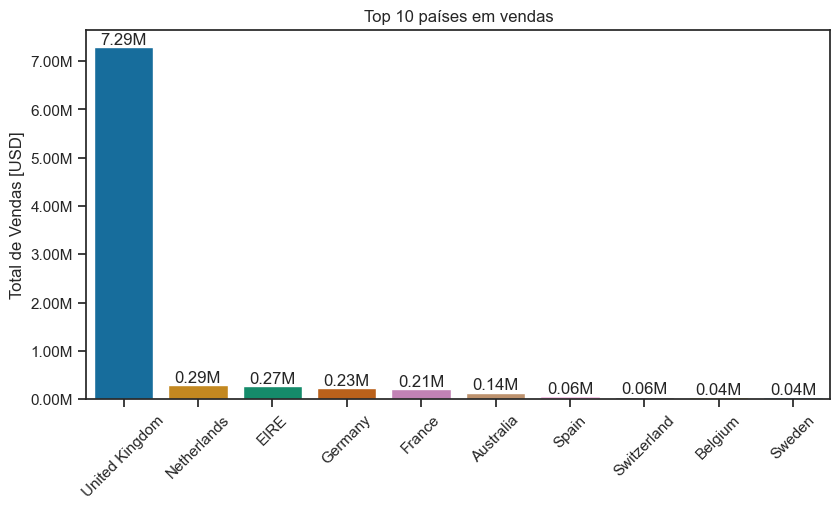

In [20]:
top10paises = df.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False)[:10]
fig, ax = plt.subplots(figsize=(6.4*1.5, 4.8))
sns.barplot(x=top10paises.index, y=top10paises.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

def million_formatter(y, pos):
    return f"{y/1e6:.2f}M"

ax.yaxis.set_major_formatter(million_formatter)
ax.set_ylabel("Total de Vendas [USD]")
ax.set_title("Top 10 países em vendas")
ax.bar_label(ax.containers[0], labels=[f"{x.get_height()/1e6:.2f}M" for x in ax.containers[0]])
ax.set_xlabel("");

Top 10 produtos mais vendidos

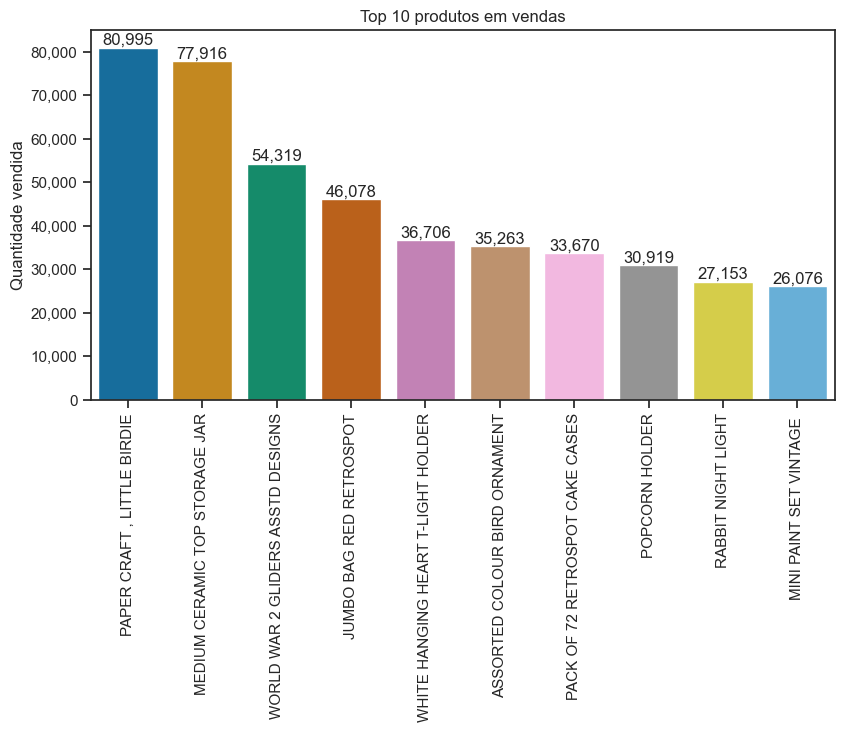

In [21]:
top10produtos = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False)[:10]
fig, ax = plt.subplots(figsize=(6.4*1.5, 4.8))
sns.barplot(x=top10produtos.index, y=top10produtos.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

def thousand_formatter(y, pos):
    return f"{y:,.0f}"

ax.yaxis.set_major_formatter(thousand_formatter)
ax.set_ylabel("Quantidade vendida")
ax.set_title("Top 10 produtos em vendas")
ax.bar_label(ax.containers[0], labels=[f"{x.get_height():,.0f}" for x in ax.containers[0]])
ax.set_xlabel("");

Valor de venda total por mês

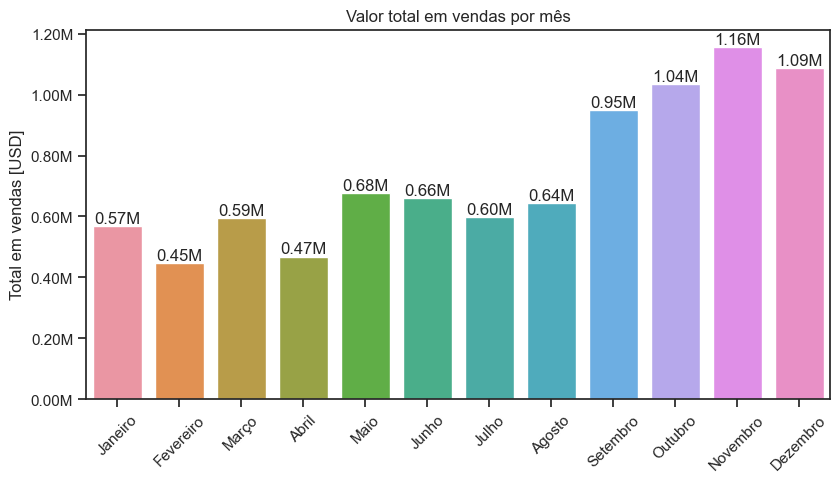

In [22]:
# Criando coluna de mês e configurando ordem
df["Month"] = df["InvoiceDate"].dt.month_name(locale="pt_BR.utf8")
ordem = ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho",
          "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"]
df["Month"] = pd.Categorical(df["Month"], categories=ordem, ordered=True)
total_mes = df.groupby("Month")["TotalPrice"].sum()
fig, ax = plt.subplots(figsize=(6.4*1.5, 4.8))
sns.barplot(x=total_mes.index, y=total_mes.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.yaxis.set_major_formatter(million_formatter)
ax.bar_label(ax.containers[0], labels=[f"{x.get_height()/1e6:.2f}M" for x in ax.containers[0]])
ax.set_xlabel("")
ax.set_ylabel("Total em vendas [USD]")
ax.set_title("Valor total em vendas por mês");

Valor de venda total por mês e por país (considerando apenas os top 10)

In [57]:
@interact(Pais=["Top 10"] + list(top10paises.index))
def bar_plot(Pais):
    df_top10 = df[df["Country"].isin(top10paises.index)]
    if Pais == "Top 10":
        data = df_top10.groupby(["Month"]).agg({"TotalPrice": "sum"})
    else:
        data = df_top10.groupby(["Country", "Month"]).agg({"TotalPrice": "sum"}).loc[Pais]
    fig, ax = plt.subplots(figsize=(6.4*1.5, 4.8))
    sns.barplot(data=data, x=data.index, y="TotalPrice")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.yaxis.set_major_formatter(million_formatter)
    ax.bar_label(ax.containers[0], labels=[f"{x.get_height()/1e6:.2f}M" for x in ax.containers[0]])
    ax.set_ylabel("Total em vendas [USD]")
    ax.set_xlabel("")
    ax.set_title("Valor total em vendas por mês");

interactive(children=(Dropdown(description='Pais', options=('Top 10', 'United Kingdom', 'Netherlands', 'EIRE',…

## Etapa 10 - Cálculo do RFM

- R é a recência, diferença em dias da última compra do cliente e da última
compra disponível no conjunto de dados, que calcularam previamente.
- F é a frequência, ou seja, a quantidade de compras feitas pelo cliente;
- M é o ticket médio, ou seja, a média das compras feitas pelo cliente.

In [25]:
# Agrupando os dados por Customer ID para criação da base RFM
RFM = df.copy().groupby("CustomerID").agg({"Quantity": "count",
                                    "TotalPrice": "mean",
                                    "InvoiceDate": "last"})
# Modificando CustomerID
RFM.index = RFM.index.str.replace(".0", "", regex=False)

# Calculando recência
RFM["Recencia"] = (last_date - RFM["InvoiceDate"]).dt.days

# Alterando nome das colunas
RFM = RFM.rename(columns={"Quantity": "Frequencia", "TotalPrice": "TicketMedio"})

# Considerando somente as colunas de RFM
RFM = RFM[["Recencia", "Frequencia", "TicketMedio"]]

# Output dos dados de RFM
RFM.to_csv("RFM.csv", index=False)